# Train a Neural Network

Here we will use Pytorch to build and train a simple neural network step-by-step. Below you will find a sample code, which you will have to finish and execute. But first things first.

Let's start with some basic imports:

As mentioned during the lesson, we will use a dataset with object images. We will also build a data loader so we can load the images from CIFAR10 dataset.

Besides the dataset, we also import `torch`, `numpy` and `torchvision` which is a library to help us with data preperation and transformations.

In [1]:
import os

#Numpy is linear algebra lbrary
import numpy as np
# Matplotlib is a visualizations library
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Load the dataset

After loading the images, we have to apply some transformations so we can feed them in the network.
Here we simply convert them to tensors and normalize them. This can be done using `transforms` from `torchvision`.

All images fall into 1 of 10 categories of things.

Let's also plot some of them to make sure that everything works fine.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

class_names = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 74075831.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# In case you wanna experiment with fashinMNIST dataset

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# # batch_size
# batch_size = 4

# # datasets
# trainset = torchvision.datasets.FashionMNIST('./data',
#     download=True,
#     train=True,
#     transform=transform)
# testset = torchvision.datasets.FashionMNIST('./data',
#     download=True,
#     train=False,
#     transform=transform)

# # dataloaders
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                         shuffle=True, num_workers=2)


# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                         shuffle=False, num_workers=2)

# # constant for classes
# classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [3]:
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)

print(train_data_size)
print(test_data_size)

50000
10000


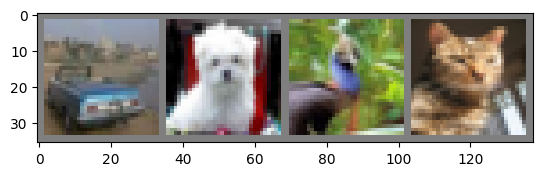

car   dog   bird  cat  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

# Build and train the model
And now for the good stuff. Let's define and train the model. This is where you will have to take action.

First you need to define a network that recieves and an input of size 3072, has 3 linear layers with dimensions 128,64,10, and 2 Relu layers in between.

Then you'll need to start the training loop by declaring the `torch.nn.CrossEntropyLoss` as our loss and `torch.optim.SGD` as our optimizer. Finally, you'll build the training loop and execute 1 or more training epochs.

In [14]:
## 1. DEFINE MODEL
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3072, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        o = self.linear3(x)

        return o

model = myModel()

In [15]:
# 2. LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

myModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3072, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [16]:
device

device(type='cuda', index=0)

In [20]:
# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0
    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset)

# Validation function
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

    return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset)

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        print(f'Epoch {epoch+1}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
              f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
              f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

    return model, history

# Example setup for DataLoader, loss function, and optimizer
# Replace with actual DataLoader code for train_dataloader and test_dataloader

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [21]:
# 4. Train the model for 10 epochs

num_epochs =10
trained_model, history = train_and_validate(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: 

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7c07b4041750><function _MultiProcessingDataLoaderIter.__del__ at 0x7c07b4041750>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
can only tes

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1: Train loss: 1.2599, Train accuracy: 0.5537, Val loss: 1.3549, Val accuracy: 0.5260, Time: 62.28s


In [22]:
history

{'train_loss': [1.2598635764849186],
 'train_accuracy': [0.5537000000000001],
 'val_loss': [1.354915692934394],
 'val_accuracy': [0.526]}

Now, we can see the the training & validation loss curve.

In [23]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

Also the accuracy plot of training & validation. What can you observe?

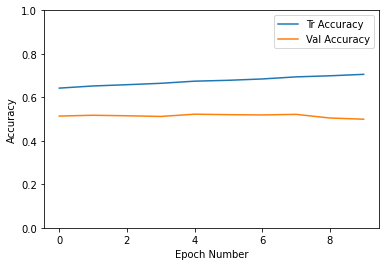

In [ ]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [ ]:
# # you can save the model
# PATH = './cifar_net.pth'
# torch.save(model.state_dict(), PATH)

After running a few training epochs, you can evaluate the trained model and compute its accuracy on unseen data. To get the prediction, we feed an image to the network and the category that has the bigger output.

Okay, first step. Let us display an image from the test set to get familiar.

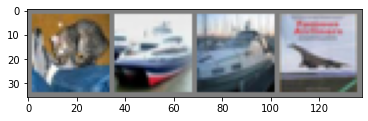

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)

images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
images.shape

torch.Size([4, 3, 32, 32])

Okay, now let us see what the neural network thinks these examples above are:

In [ ]:
# again, need to flatten the image
images = images.to(device)
images = images.view(images.size(0), -1)
outputs = model(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  bird 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 49 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 52.5 %
Accuracy for class: car   is 56.0 %
Accuracy for class: bird  is 43.4 %
Accuracy for class: cat   is 26.8 %
Accuracy for class: deer  is 35.8 %
Accuracy for class: dog   is 44.7 %
Accuracy for class: frog  is 68.6 %
Accuracy for class: horse is 51.1 %
Accuracy for class: ship  is 70.5 %
Accuracy for class: truck is 50.0 %


## Confusion Matrix

Finally, you might want to visualize which class the model predicts well and which class are more challenging. This can be done through the inspection of confusion matrix.

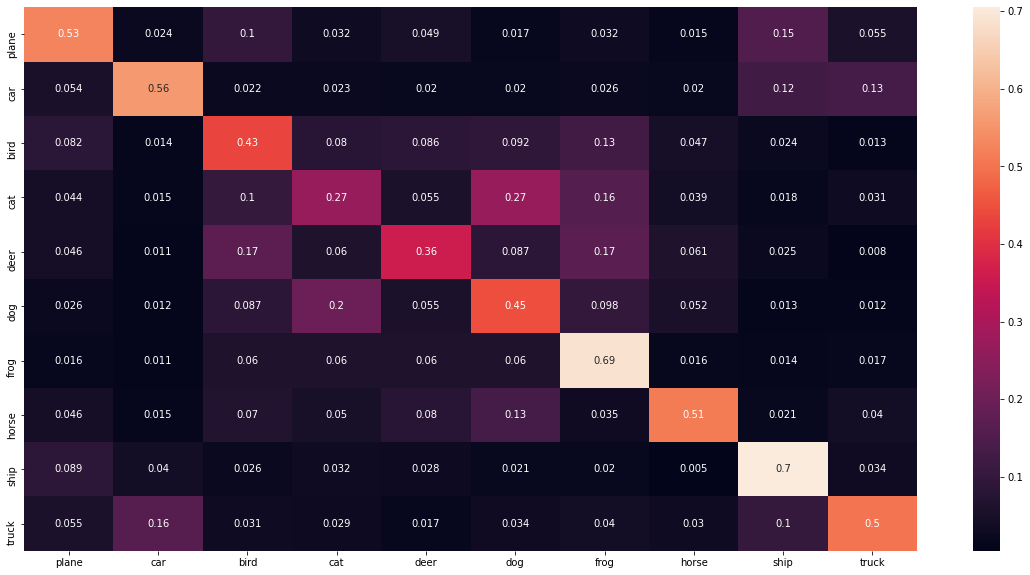

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in testloader:
        #reshape images so they can be fed to a nn.Linear()
        inputs = inputs.view(inputs.size(0), -1)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')